## Testing Manual Particle Movement Experiment Calibration


In [7]:
import os
import re
import numpy as np
import librosa
import scipy.signal
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import OrderedDict

#### Import calibration file and checking left and right gain to see which is the impact pipe

C:\Users\nicol\AppData\Local\Temp\ipykernel_16032\56214427.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\nicol\anaconda3\envs\hydrophones\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


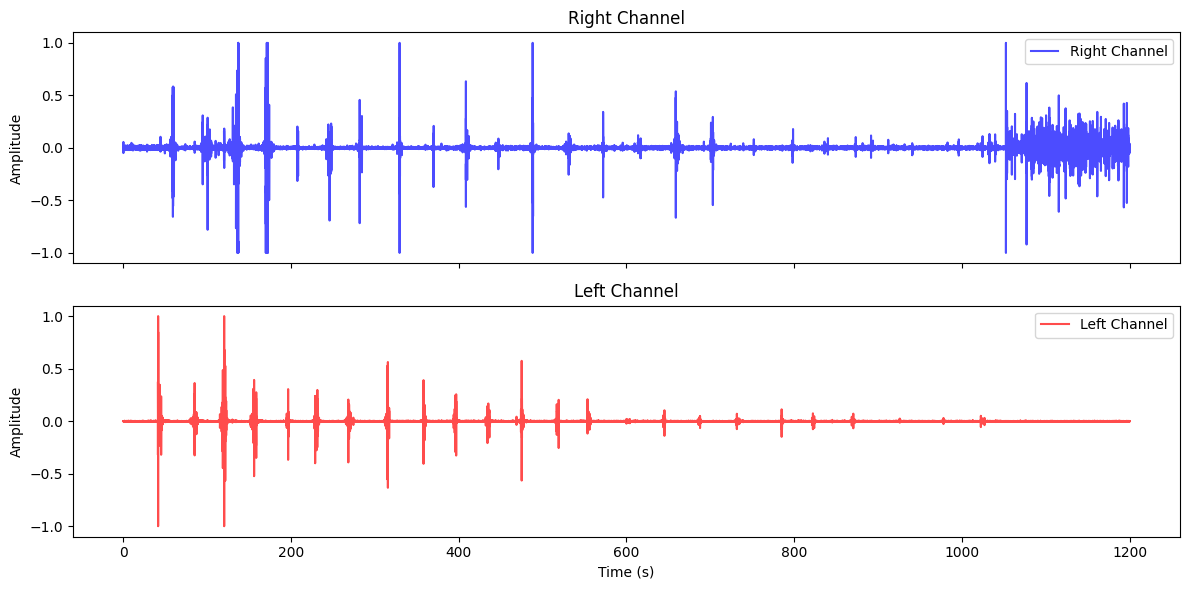

In [2]:
filepath = 'ManualRockMovements-1/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()


The left channel is the impact pipe. This is true for all calibration recordings for H1 in 2023

#### Compute and plotting envelope

In [20]:
# === USER INPUT ===
left_gain_db = 6   # left channel gain (dB)
right_gain_db = 12 # right channel gain (dB)
use_channel = "left"  # or "right"

# convert dB gain to linear - linear amplitude ratio
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# choose channel and correct for gain
y = signal[0] if use_channel == "left" else signal[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# compute envelope
analytic_signal = scipy.signal.hilbert(y)
envelope = np.abs(analytic_signal)

# estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 40 * noise_level

# detect packet start/end points
above_thresh = envelope > threshold # boolean array indicating where the envelope is above the threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0] # where the envelope crosses above the threshold
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0] # where the envelope crosses below the threshold

# remove any packets that are too short (less than 0.1 seconds)
if packet_ends[0] < packet_starts[0]: 
    packet_ends = packet_ends[1:] 
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

Plotting envelope and packets

C:\Users\nicol\AppData\Local\Temp\ipykernel_16032\4174856207.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


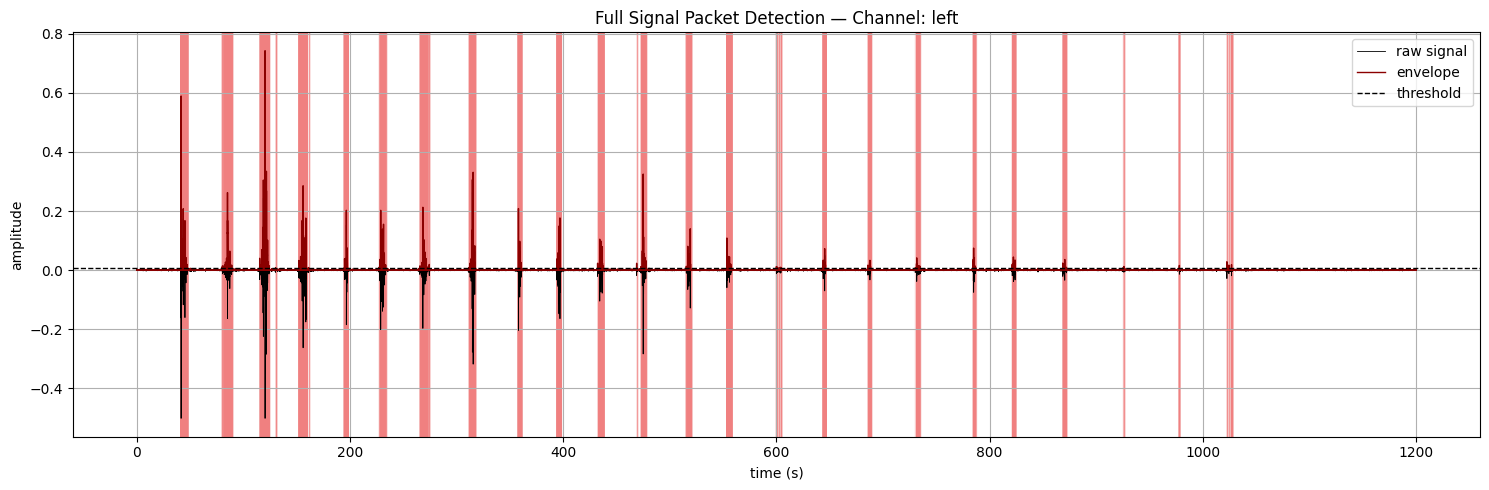

In [21]:
time = np.arange(len(y)) / sr

# === Plot ===
plt.figure(figsize=(15, 5))
plt.plot(time, y, color='black', linewidth=0.6, label="raw signal")
plt.plot(time, envelope, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# shade packet zones
for s, e in zip(packet_starts, packet_ends):
    plt.axvspan(time[s], time[e], color='lightcoral', alpha=0.4)

# De-duplicate Δtₚ label in legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]  # safety check
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Full Signal Packet Detection — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()
plt.show()

Max amplitude in the zoomed-in window: 0.29


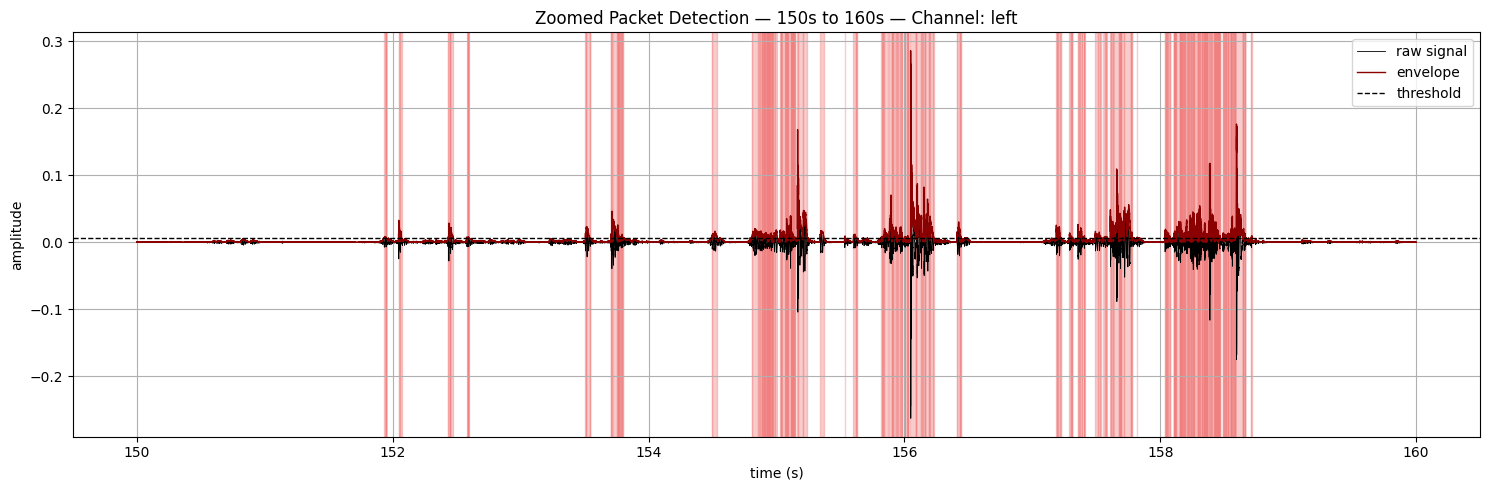

In [42]:
start_time = 150  # in seconds
end_time = 160    # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# Only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# Clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Zoomed Packet Detection — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.2f}")

plt.show()



In [19]:
# how many packets were detected?
print(f"Detected {len(packet_starts)} packets in {len(y)/sr:.2f} seconds of audio.")

Detected 2028 packets in 1200.00 seconds of audio.


Re-plotting with time windows - First Packet

Max amplitude in the zoomed-in window: 0.59


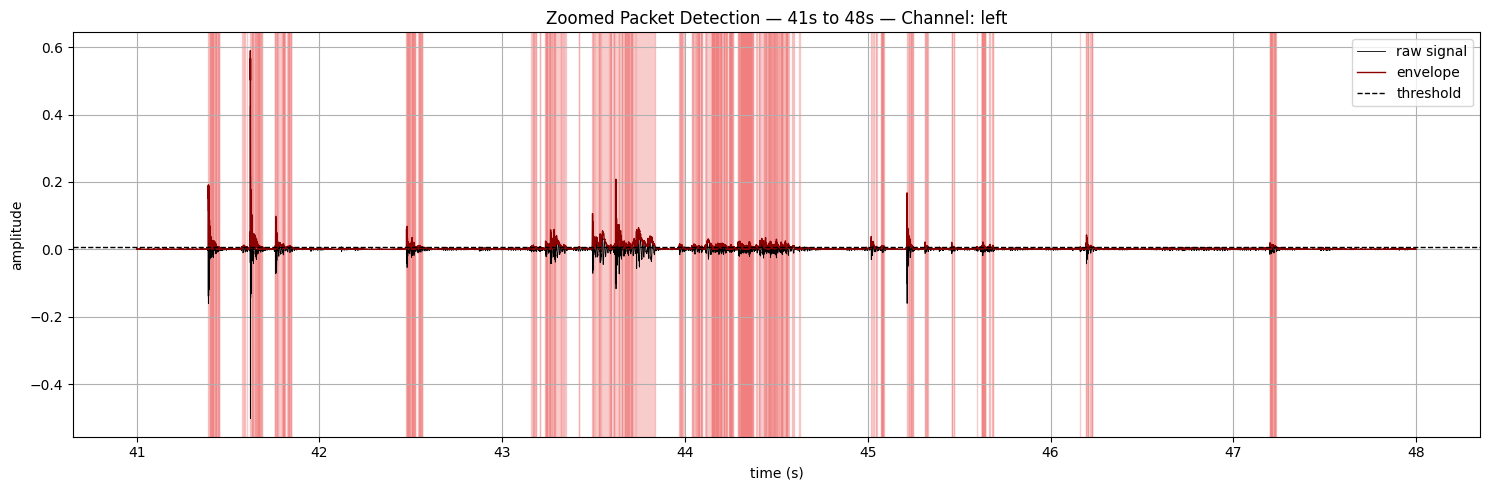

In [37]:
start_time = 41  # in seconds
end_time = 48    # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# Only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# Clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Zoomed Packet Detection — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()

# calculate the max amplitude of envelope in this window
max_amplitude_zoom = np.max(np.abs(envelope_zoom))
print(f"Max amplitude in the zoomed-in window: {max_amplitude_zoom:.2f}")

plt.show()

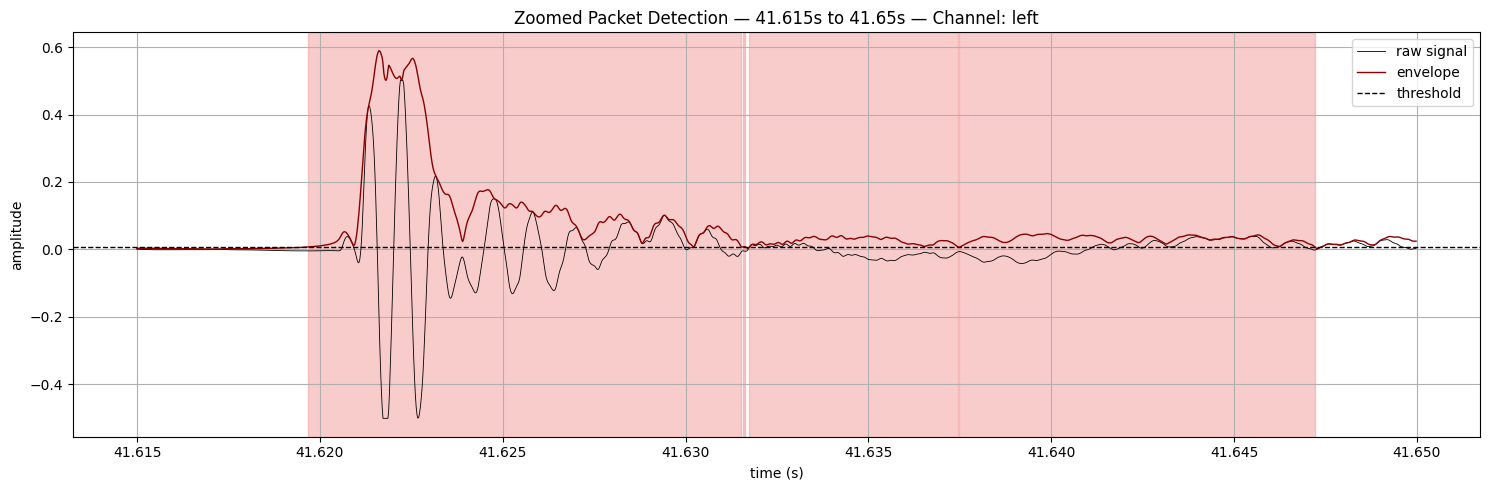

In [28]:
start_time = 41.615  # in seconds
end_time = 41.65   # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# Only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# Clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Zoomed Packet Detection — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()
plt.show()

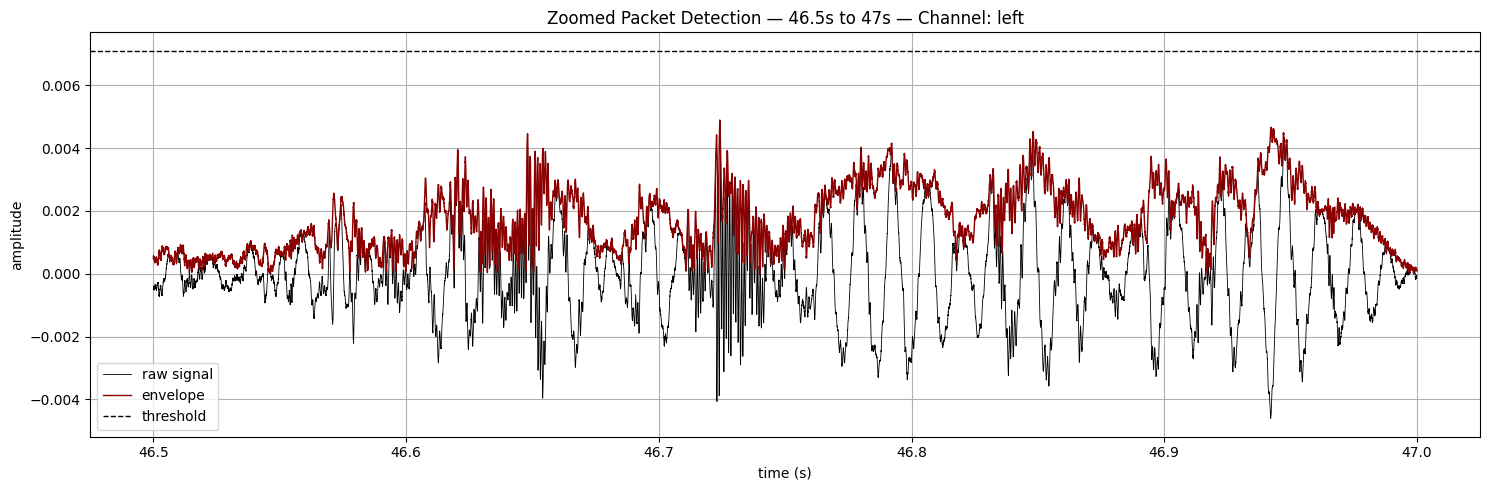

In [38]:
start_time = 46.5  # in seconds
end_time = 47   # in seconds

# convert times to sample indices
start_idx = int(start_time * sr)
end_idx = int(end_time * sr)

# slice all relevant arrays to just this window
y_zoom = y[start_idx:end_idx]
envelope_zoom = envelope[start_idx:end_idx]
time_zoom = np.arange(start_idx, end_idx) / sr

# Plot (zoomed-in view) 
plt.figure(figsize=(15, 5))
plt.plot(time_zoom, y_zoom, color='black', linewidth=0.6, label="raw signal")
plt.plot(time_zoom, envelope_zoom, color='darkred', linewidth=1.0, label="envelope")
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, label="threshold")

# Only show shaded packets that fall within the zoomed-in range
for start, end in zip(packet_starts, packet_ends):
    if start >= start_idx and end <= end_idx:
        plt.axvspan(start / sr, end / sr, color='lightcoral', alpha=0.4)

# Clean up legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ["Δtₚ" if "Patch" in str(h) else l for h, l in zip(handles, labels)]
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.title(f"Zoomed Packet Detection — {start_time}s to {end_time}s — Channel: {use_channel}")
plt.grid(True)
plt.tight_layout()
plt.show()